# Initial Preprocessing of UW-Madison Data
## (into 2D arrays - npy and png format)

This file performs initial preprocessing of the UW-Madison dataset,
starting with the data as provided for the Kaggle competition,
and targeting traditional 2D representations in .npy and .png formats.

`---`
The dataset comes from the UWMadison GI-Track Segmentation Kaggle Competition:

* https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/

The code here is largely copied/reused from an example provided by Kaggle competitor "AWSAF49"
* https://www.kaggle.com/code/awsaf49/uwmgi-mask-data

---

The input to this script is the dataset as provided for the competition
* 2.3G uw-madison-gi-tract-image-segmentation.zip

Once unzipped it includes
* MRI samples within a folder hierarchy which identifies the case (patient), day, and scan (slice).
* A single "training.csv" file that contains run-length encoding (RLE) of 3 segments of the brain, for a subset of the images.

An MRI is a set of scans that represent a 3D volume. Each scan is a 2D slice through the brain at a particular depth. Scans are in .png format and are a 16-bit grayscale image. Scans are co-located in the folder with it's peers for that MRI. 

A patient typically has several MRI samples, taken on different days.

---

This file performs the following:
* RLE segmentation data for [large_bowel, small_bowel, stomach] is read and used to generate a mask of dimensions [H,W,3]. Each pixel is uint8, and has a value of either 0 or 255. The third dimension, having size three represents the three classes. So for example if mask [x,y,0]=0 then the image pixel is considered not a large_bowl, if it is "255" then it IS a large bowl.
* Note that a [H,W,3] array can be considered RGB - that makes the masks directly viewable as an RGB image.
* The masks are written to two file formats (.png and .npy).
* NOTE the grayscale MRI images themselves are not modified or copied at all... only masks are generated and written to file.

Finally - note that everything here is considered 2D images, not 3D "voxels".

# Import Libraries

In [14]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Weights & Biases

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

In [15]:
import wandb
wandb.login()

# try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     api_key = user_secrets.get_secret("WANDB")
#     wandb.login(key=api_key)
# except:
#     wandb.login(anonymous='must',relogin=True)
#     print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

True

# Configs

In [16]:
NUM_LOG = 10 # number of interactive Visualiztions to be saved to for WandB
NO_EMPTY = True # set False to include images with empty mask in WandB

# Utilities

In [17]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


# Metadata

In [18]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

# Mask

In [19]:
def id2mask(id_, df=None):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

# Image

In [20]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

# Read Case/Segmentation Data

In [21]:
df = pd.read_csv('/mnt/d/code_medimg_practice/data/train.csv')
# df = df.progress_apply(get_metadata, axis=1)
df = df.apply(get_metadata, axis=1)
df.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1
2,case123_day20_slice_0001,stomach,NaN,123,20,1
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2


# Merge in Paths to Images

In [23]:
paths = glob('/mnt/d/code_medimg_practice/data/train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])
# path_df = path_df.progress_apply(path2info, axis=1)
path_df = path_df.apply(path2info, axis=1)
df = df.merge(path_df, on=['case','day','slice'])
df.head()

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/mnt/d/code_medimg_practice/data/train/case123...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/mnt/d/code_medimg_practice/data/train/case123...,266,266


# Check Mask

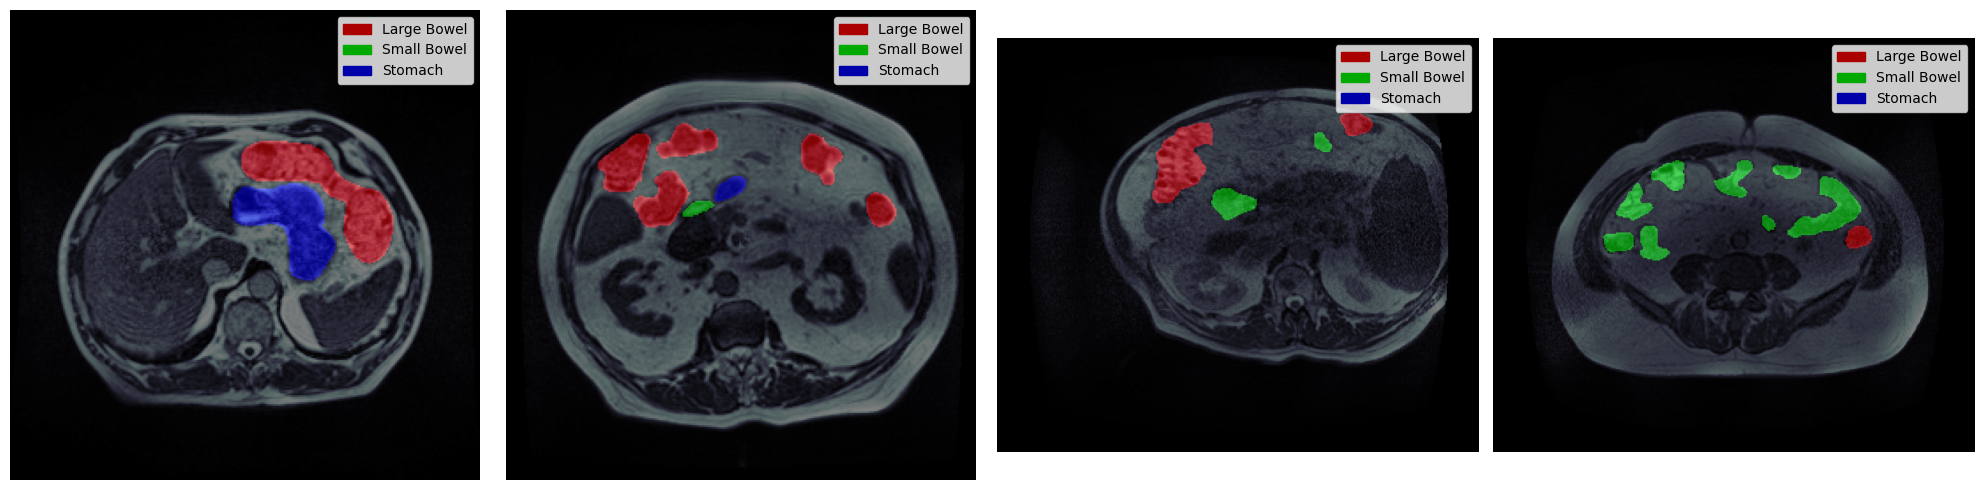

In [24]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
# the following line samples (row*col) unique IDs from that subset of the dataframe where "segmentation" is not N/A
# In other words - get four samples that have segmentation
for i, id_ in enumerate(df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row*col]):
    img = load_img(df[df['id']==id_].image_path.iloc[0])
    mask = id2mask(id_,df=df)*255
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

# temporary - explore image and mask

in summary: df includes (3) entries for each image (a.k.a. case_id) - one for each segment
for example:
```
case34_day0_slice_0067
/mnt/d/code_medimg_practice/data/train/case34/case34_day0/scans/slice_0067_276_276_1.63_1.63.png
/mnt/d/code_medimg_practice/data/train/case34/case34_day0/scans/slice_0067_276_276_1.63_1.63.png
/mnt/d/code_medimg_practice/data/train/case34/case34_day0/scans/slice_0067_276_276_1.63_1.63.png
```
### Image
* An image is read from file using the load_img() function.
* That function performs only basic processing - converting from uint16 to uint8, and cropping values
* That function returns a numpy array of uint8 (between 0 and 255). Shape is variable.
* Image pixel values are a skewed mostly lower values.

### Mask
* A "mask" is generated using the id2mask function.
* That function:
  * generates a zero array having [height, width] same as the image, but with additional dimension of [3]
  * the pixels of that array are of type uint8
  * for each of the (3) segmentation RLE sequences ['large_bowel', 'small_bowel', 'stomach']
    * use the rle_decode to populate the array for that dimension 
  * the resulting array of shape [height, width, 3] having type uint8.
  * the resulting array has pixel values of [0,1] indicating pixel is of that segment type. The application performs *255 resulting in pixel values of [0, 255].




In [65]:
### explore...

# randomly sample from the dataframe, where segmentation is present, and choose the first
case_id = df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[0]
print(case_id)

for y in (df[df['id']==case_id].image_path):
    print(y)

img = load_img(df[df['id']==case_id].image_path.iloc[0])
print(f"\ntype(img) {type(img)} img.shape {img.shape} type(img[0,0]) {type(img[0,0])}")
[print(y) for y in np.histogram(img)]


mask = id2mask(case_id, df=df)
print(f"\ntype(mask) {type(mask)} mask.shape {mask.shape} type(mask[0,0,0] {type(mask[0,0,0])}")
# [print(y) for y in np.histogram(mask[:,:,0])]
_ = [print(y) for y in np.histogram(mask[:,:,0])]
_ = [print(y) for y in np.histogram(mask[:,:,1])]
_ = [print(y) for y in np.histogram(mask[:,:,2])]



case55_day20_slice_0110
/mnt/d/code_medimg_practice/data/train/case55/case55_day20/scans/slice_0110_266_266_1.50_1.50.png
/mnt/d/code_medimg_practice/data/train/case55/case55_day20/scans/slice_0110_266_266_1.50_1.50.png
/mnt/d/code_medimg_practice/data/train/case55/case55_day20/scans/slice_0110_266_266_1.50_1.50.png

type(img) <class 'numpy.ndarray'> img.shape (266, 266) type(img[0,0]) <class 'numpy.uint8'>
[27255 10235  9065  7250  5937  7091  3216   580   113    14]
[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]

type(mask) <class 'numpy.ndarray'> mask.shape (266, 266, 3) type(mask[0,0,0] <class 'numpy.uint8'>
[70011     0     0     0     0     0     0     0     0   745]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[69041     0     0     0     0     0     0     0     0  1715]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[70404     0     0     0     0     0     0     0     0   352]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


# Initiate Weights&Biases project

In [69]:
# Initialize WANDB project
run = wandb.init(project='uwmgi-mask-data', 
                 config={},
#                  anonymous=anonymous,
                 name=f"01a_initial_preprocessing_to_2d_png_npy",
                )
# Columns for wandb table
columns=["id", "case", "day", "slice", "empty", "image"]
# Initialize table
table = wandb.Table(columns=columns)
# Labels for mask
class_labels = {
#     0:"Background",
    1:"Large Bowel",
    2:"Small Bowel",
    3:"Stomach",
}

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


# Write Mask

In [72]:
def save_mask(id_,df=None, count=0):
    # print(count)
    # print(df.head())
    # assert False, "hold up"
    
    idf = df[df['id']==id_]
    mask = id2mask(id_, df=df)  # mask is [height, width, 3] and values are [0, 1] 
    image_path = idf.image_path.iloc[0]
    img = load_img(image_path) # load image
    # mask_path = image_path.replace('/kaggle/input/','/tmp/png/')
    mask_path = image_path.replace(
        '/mnt/d/code_medimg_practice/data/train/',
        '/mnt/d/code_medimg_aneja_lab/data_uwmadison_01_preprocessed/tmp/png/')

    mask_folder = mask_path.rsplit('/',1)[0]
    os.makedirs(mask_folder, exist_ok=True)
    cv2.imwrite(mask_path, mask*255, [cv2.IMWRITE_PNG_COMPRESSION, 1]) # convert mask values to [0, 255] and write as .png
    # mask_path2 = image_path.replace('/kaggle/input/','/tmp/np/').replace('.png','.npy')
    mask_path2 = image_path.replace(
        '/mnt/d/code_medimg_practice/data/train/',
        '/mnt/d/code_medimg_aneja_lab/data_uwmadison_01_preprocessed/tmp/np/').replace('.png','.npy')
    
    mask_folder2 = mask_path2.rsplit('/',1)[0]
    os.makedirs(mask_folder2, exist_ok=True)
    np.save(mask_path2, mask*255) # convert mask values to [0, 255] and write as .npy
    # log some images in WandB table
    if count<=NUM_LOG:
        img = cv2.resize(img, dsize=(160, 192), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, dsize=(160, 192), interpolation=cv2.INTER_NEAREST)
        table.add_data(id_, 
                       idf.case.iloc[0], 
                       idf.day.iloc[0],
                       idf.slice.iloc[0],
                       int(mask.sum()==0),
                       wandb.Image(img, masks={
    #         "predictions" : {
    #             "mask_data" : prediction,
    #             "class_labels" : class_labels
    #         },
            "ground_truth" : {
                "mask_data" : rgb2gray(mask), # (height, width, 3) => (height, width) => may lose overlap data
                "class_labels" : class_labels
            }}))
    return mask_path

In [73]:
tmp_df = df.copy()
print(f"NO_EMPTY={NO_EMPTY}")
if NO_EMPTY:
    tmp_df = tmp_df[~df.segmentation.isna()]
ids = tmp_df['id'].unique()
# Save Mask
# _ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
#                                              for i, id_ in enumerate(tqdm(ids, total=len(ids))))
# for i, id_ in enumerate(ids):
#     save_mask(id_, df=tmp_df, count=i)
# _ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
#                                             for i, id_ in enumerate(tqdm(ids)))
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
                                            for i, id_ in enumerate(ids))

NO_EMPTY=True
